This notebook contatins experiments with IAF. This model seems to be extremely tricky to train as it produces artifacts almost always

In [1]:
!git clone https://github.com/katyafilimoshina/tsc_msc_dl.git
!git clone https://github.com/MaximArtemev/nflib
!pip install pyro-ppl normflows

Cloning into 'tsc_msc_dl'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 100 (delta 43), reused 22 (delta 6), pack-reused 0
Receiving objects: 100% (100/100), 4.19 MiB | 7.43 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Cloning into 'nflib'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 44 (delta 6), reused 6 (delta 6), pack-reused 33
Receiving objects: 100% (44/44), 2.16 MiB | 6.88 MiB/s, done.
Resolving deltas: 100% (12/12), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none

In [2]:
import sys
sys.path.append("/content/tsc_msc_dl/")
sys.path.append("/content/nflib/")

In [3]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.nn import KLDivLoss
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Categorical, Normal

import pyro
from pyro.infer import MCMC, HMC as pyro_hmc, NUTS as pyro_nuts

from tqdm.notebook import tqdm, trange
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

from distributions import Funnel, Banana
from samplers import ISIR, NUTS, HMC

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

from nflib.flows import IAF, NormalizingFlowModel

import normflows as nf
from normflows.flows.base import Flow

# TSC

In [15]:
torch.manual_seed(0xAB0BA)

dim = 2

# Init variational distribution

proposal = nf.distributions.base.GaussianMixture(n_modes = 2, dim = dim, trainable=True)
#proposal = Cauchy(dim=dim, loc=loc, scale=scale)
target = Banana(dim=dim, b=0.02)

# Init flow
latent_size = dim
num_layers = 2
flows_layers = [IAF(dim=dim, parity=i%2) for i in range(num_layers)]

flow_model = NormalizingFlowModel(proposal, flows_layers).to(torch.float64)

N_CHAINS = torch.tensor(1)
N_SAMPLES = 10
BURN_IN = 10

optimizer_q = optim.Adam(lr=1e-4, params=proposal.parameters(), weight_decay=1e-5)
scheduler_q = StepLR(optimizer_q, 1, gamma=1 - 1e-2)

optimizer_nf = optim.Adam(lr=1e-4, params=flow_model.parameters(), weight_decay=1e-5)
scheduler_nf = StepLR(optimizer_q, 1, gamma=1 - 1e-3)

list(proposal.parameters())

[Parameter containing:
 tensor([[[ 0.1850,  0.5870],
          [ 0.8050, -0.0531]]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[[0., 0.],
          [0., 0.]]], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([[-0.6931, -0.6931]], dtype=torch.float64, requires_grad=True)]

In [16]:
n_iter = 10**3
loss_arr = []
z_0 = proposal.sample(N_CHAINS)

for i in tqdm(range(n_iter)):

    if i % 1000 == 0:
      z_0 = proposal.sample(N_CHAINS)

    chains = HMC(
                  z_0,
                  target,
                  N_SAMPLES,
                  BURN_IN,
                  step_size = 0.05,
                  num_leapfrog_steps = 20,
                  verbose = False,
                )
    chains_no_grad = chains.detach()

    zs, prior_logprob, log_det = flow_model.forward(chains_no_grad.squeeze())
    z = zs[-1]

    # if (i % 990 == 0):
    #   print("Proposal log, Det log:", proposal.log_prob(z), log_det)
    #   print("Scale:", scale)
    #   print("Loc:", loc)

    # log_q = proposal.log_prob(z)
    # log_p = target.log_prob(z)

    loss = (log_det - prior_logprob).mean()
    # loss = KL_div(log_p, log_q, log_det)

    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()

        optimizer_nf.step()
        # scheduler_nf.step()
        optimizer_nf.zero_grad()

        optimizer_q.step()
        # scheduler_q.step()
        optimizer_q.zero_grad()

    with torch.no_grad():
        z_0, log_det = flow_model.backward(z)
        z_0 = z_0[-1][-1]
        # loss_arr.append(loss.detach().item()/log_q.shape[0])
        loss_arr.append(loss.detach().item())

  0%|          | 0/1000 [00:00<?, ?it/s]

Warmup:   0%|          | 0/20 [00:00, ?it/s]

KeyboardInterrupt: 

Sample: 100%|██████████| 1010/1010 [00:03, 294.41it/s, step size=1.13e+00, acc. prob=0.808]


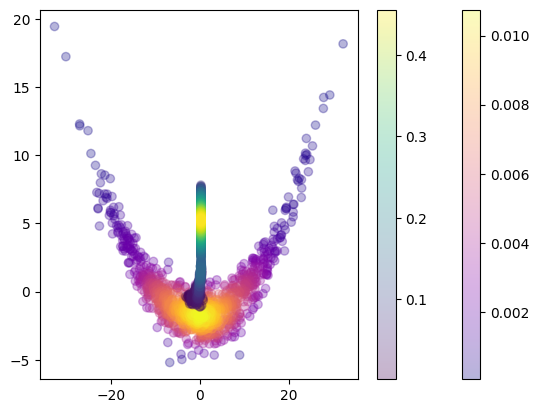

In [18]:
# Now target
points = target.sample(1000)

# Generate points from distribution
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='plasma', alpha=0.3)
plt.colorbar()

# Now what we sampled
z_0 = proposal.sample(N_CHAINS)

chains = HMC(
            z_0,
            target,
            1000,
            BURN_IN,
            step_size = 0.01,
            num_leapfrog_steps = 20,
            verbose = False,
            )
with torch.no_grad():
    result = flow_model.forward(chains.squeeze())
    points = result[0][-1]

# Generate points from distribution
# points = chains[:, 0]
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='viridis', alpha=0.3)
plt.colorbar()

plt.show()
plt.close()

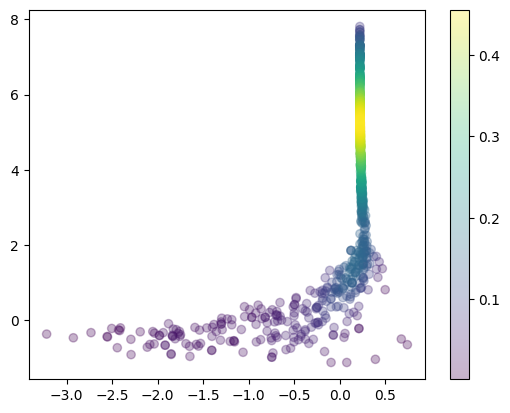

In [19]:
X = points[:, 0]
Y = points[:, 1]

# Calculate the point density
XY = torch.stack([points[:, 0], points[:, 1]], dim=0).numpy()
Z = gaussian_kde(XY)(XY)

# Sort the points by density, so that the densest points are plotted last
idx = Z.argsort()
X, Y, Z = X[idx], Y[idx], Z[idx]

plt.scatter(X, Y, c=Z, label=Z, cmap='viridis', alpha=0.3)
plt.colorbar()

plt.show()
plt.close()